In [ ]:
# Run on google colab only
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/DRL-based-Recommendation'

import os
os.chdir(root_path)

In [1]:
from model import Actor, Critic, DRRAveStateRepresentation, PMF
from learn import DRRTrainer
from utils.general import csv_plot
import torch
import pickle
import numpy as np
import random
import os
import datetime

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class config():
    output_path = 'results/' + datetime.datetime.now().strftime('%y%m%d') + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plot_dir = output_path + 'rewards.pdf'

    train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
    train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
    train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'

    train_actor_loss_plot_dir = output_path + 'train_actor_loss.png'
    train_critic_loss_plot_dir = output_path + 'train_critic_loss.png'
    train_mean_reward_plot_dir = output_path + 'train_mean_reward.png'

    trained_models_dir = 'trained/'

    actor_model_trained = trained_models_dir + 'actor_net.weights'
    critic_model_trained = trained_models_dir + 'critic_net.weights'
    state_rep_model_trained = trained_models_dir + 'state_rep_net.weights'

    actor_model_dir = output_path + 'actor_net.weights'
    critic_model_dir = output_path + 'critic_net.weights'
    state_rep_model_dir = output_path + 'state_rep_net.weights'

    csv_dir = output_path + 'log.csv'

    path_to_trained_pmf = trained_models_dir + 'trained_pmf.pt'

    # hyperparams
    batch_size = 64
    gamma = 0.9
    replay_buffer_size = 100000
    history_buffer_size = 5
    learning_start = 1000
    learning_freq = 1
    lr_state_rep = 0.001
    lr_actor = 0.0001
    lr_critic = 0.001
    eps_start = 1
    eps = 0.1
    eps_steps = 10000
    eps_eval = 0.1
    tau = 0.01 # inital 0.001
    beta = 0.4
    prob_alpha = 0.3
    max_timesteps_train = 100000
    max_epochs_offline = 1000
    max_timesteps_online = 10000
    embedding_feature_size = 100
    episode_length = 10
    train_ratio = 0.8
    weight_decay = 0.01
    clip_val = 1.0
    log_freq = 100
    saving_freq = 1000
    zero_reward = False
    enable_cuda = False

def seed_all(cuda, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed=seed)

In [4]:
# Get CUDA device if available
cuda = True if config.enable_cuda and torch.cuda.is_available() else False
print("Using CUDA") if cuda else print("Using CPU")

# Init seeds
seed_all(cuda, 0)

# Grab models
actor_function = Actor
critic_function = Critic
state_rep_function = DRRAveStateRepresentation

# Import Data
users = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset/item_id_to_num.pkl', 'rb'))
data = np.load('dataset/data.npy')

# Normalize rewards to [-1, 1]
data[:, 0] = 0.5 * (data[:, 0] - 3)
# print(data)

np.random.shuffle(data)
train_data = torch.from_numpy(data[:int(config.train_ratio * data.shape[0])])
test_data = torch.from_numpy(data[int(config.train_ratio * data.shape[0]):])

# Create and load PMF function for rewards and embeddings
n_users = len(users)
n_items = len(items)
reward_function = PMF(n_users, n_items, config.embedding_feature_size, is_sparse=False, enable_cuda=cuda)
reward_function.load_state_dict(torch.load(config.path_to_trained_pmf))

# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")

# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data
print("Extracted user and item embeddings from PMF")
print("User embeddings shape: ", user_embeddings.shape)
print("Item embeddings shape: ", item_embeddings.shape)

# Init trainer
print("Initializing DRRTrainer -------------------------------------------------------------------------------")
trainer = DRRTrainer(config,
                      actor_function,
                      critic_function,
                      state_rep_function,
                      reward_function,
                      users,
                      items,
                      train_data,
                      test_data,
                      user_embeddings,
                      item_embeddings,
                      cuda
                      )

Using CPU
Initialized PMF, imported weights, created reward_function
Extracted user and item embeddings from PMF
User embeddings shape:  torch.Size([6040, 100])
Item embeddings shape:  torch.Size([3883, 100])
Initializing DRRTrainer -------------------------------------------------------------------------------
Current PyTorch Device:  cpu
Data dimensions extracted
Models initialized
Model weights initialized, copied to target
Optimizers initialized


/tmp/ipykernel_37944/2036903296.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_function.load_state_dict(torch.load(config.path_to_trained_pmf))


In [5]:
%%time
# Train
actor_losses, critic_losses, epi_avg_rewards = trainer.learn()

/home/tori/Tori/DRR/learn.py:251: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 9 | Mean Ep R 0.3680 | Max R 0.3680 | Critic Params Norm 0.1061 | Actor Loss -0.8672 | Critic Loss 0.0894 | 
Timestep 200 | Episode 19 | Mean Ep R 0.0000 | Max R 0.0000 | Critic Params Norm 0.6578 | Actor Loss -1.7309 | Critic Loss 0.0860 | 
Timestep 300 | Episode 29 | Mean Ep R 0.7876 | Max R 0.7876 | Critic Params Norm 0.4787 | Actor Loss -2.2041 | Critic Loss 0.1119 | 
Timestep 400 | Episode 39 | Mean Ep R 0.0000 | Max R 0.0000 | Critic Params Norm 0.7987 | Actor Loss -3.2458 | Critic Loss 0.0857 | 
Timestep 500 | Episode 49 | Mean Ep R 0.3798 | Max R 0.3798 | Critic Params Norm 0.4893 | Actor Loss -3.0587 | Critic Loss 0.0771 | 
Timestep 600 | Episode 59 | Mean Ep R 0.6505 | Max R 0.6505 | Critic Params Norm 0.1469 | Actor Loss -3.7707 | Critic Loss 0.0612 | 
Timestep 700 | Episode 69 | Mean Ep R 0.0000 | Max R 0.0000 | Critic Params Norm 0.8952 | Actor Loss -5.3072 | Critic Loss 0.0859 | 
Timestep 800 | Episode 79 | Mean Ep R 0.5369 | Max R 0.5369 | Critic P

In [6]:
# Change to newest trained data directories
# config.trained_models_dir = config.output_path
# output_path = config.output_path
config.trained_models_dir = "results/241202/"
output_path = "results/241202/"

train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'

config.actor_model_trained = config.trained_models_dir + 'actor_net.weights'
config.critic_model_trained = config.trained_models_dir + 'critic_net.weights'
config.state_rep_model_trained = config.trained_models_dir + 'state_rep_net.weights'

In [7]:
!pip install tsmoothie

def noiseless_plot(y, title, ylabel, save_loc):
  # operate smoothing
  smoother = ConvolutionSmoother(window_len=1000, window_type='ones')
  smoother.smooth(y)

  # generate intervals
  low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

  # plot the smoothed timeseries with intervals
  plt.close()
  plt.figure(figsize=(11,6))
  plt.xlabel("Epoch")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.plot(smoother.data[0], color='orange')
  plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
  plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
  plt.savefig(save_loc)
  plt.close()


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

actor_losses = np.load(train_actor_loss_data_dir)
critic_losses = np.load(train_critic_loss_data_dir)
epi_avg_rewards = np.load(train_mean_reward_data_dir)

noiseless_plot(actor_losses,
               "Actor Loss (Train)",
               "Actor Loss (Train)",
               output_path + "train_actor_loss_smooth.png")

noiseless_plot(critic_losses,
               "Critic Loss (Train)",
               "Critic Loss (Train)",
               output_path + "train_critic_loss_smooth.png")

noiseless_plot(epi_avg_rewards,
               "Mean Reward (Train)",
               "Mean Reward (Train)",
               output_path + "train_mean_reward_smooth.png")

Save hyperparameters.

In [9]:
sourceFile = open(output_path + "hyperparams.txt", 'w')
print(config.__dict__, file = sourceFile)
sourceFile.close()

**Run** Offline and Online evaluations, save scores.

In [10]:
T_ndcgs = [5, 10, 20]

In [11]:
# Offline evaluate

# PMF
print("Start PMF")
for T_ndcg in T_ndcgs:
  pmf_Ts = []
  for i in range(20):
    print(f"PMF - Time #{i}:")
    # Evaluate
    avg_ncdg = trainer.offline_pmf_evaluate(T_ndcg)

    # Append to list
    pmf_Ts.append(avg_ncdg)

  # Save data
  pmf_Ts = np.array(pmf_Ts)
  np.save(output_path + f'avg_ndcg@{T_ndcg}_offline_pmf_eval.npy', pmf_Ts)

  # Save
  sourceFile = open(output_path + f'avg_ndcg@{T_ndcg}_offline_pmf_eval.txt', 'w')
  print(f'Average NDCG@{T_ndcg} (Eval): {np.mean(pmf_Ts)}', file=sourceFile)
  sourceFile.close()

# DRR
print("Start DRR")
for T_ndcg in T_ndcgs:
  drr_Ts = []
  for i in range(20):
    print(f"DRR - Time #{i}:")
    # Evaluate
    avg_ndcg = trainer.offline_evaluate(T_ndcg)

    # Append to list
    drr_Ts.append(avg_ndcg)

  # Save data
  drr_Ts = np.array(drr_Ts)
  np.save(output_path + f'avg_ndcg@{T_ndcg}_offline_eval.npy', drr_Ts)

  # Save
  sourceFile = open(output_path + f'avg_ndcg@{T_ndcg}_offline_eval.txt', 'w')
  print(f'Average NDCG@{T_ndcg} (Eval): {np.mean(drr_Ts)}', file=sourceFile)
  sourceFile.close()

Start PMF
PMF - Time #0:
Episode 20 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6227 | 
Episode 40 | NDCG@5 0.6121147797198481 | Avg NDCG@5 0.6318 | 
Episode 60 | NDCG@5 0.6289509357448472 | Avg NDCG@5 0.6227 | 
Episode 80 | NDCG@5 0.6121147797198481 | Avg NDCG@5 0.6183 | 
Episode 100 | NDCG@5 0.6404015779112127 | Avg NDCG@5 0.6207 | 


/home/tori/Tori/DRR/learn.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.state_rep_net.load_state_dict(torch.load(self.config.state_rep_model_trained))
/home/tor

Episode 120 | NDCG@5 0.6121147797198481 | Avg NDCG@5 0.6177 | 
Episode 140 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6157 | 
Episode 160 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6152 | 
Episode 180 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6191 | 
Episode 200 | NDCG@5 0.6121147797198481 | Avg NDCG@5 0.6193 | 
Episode 220 | NDCG@5 0.6294456402014998 | Avg NDCG@5 0.6183 | 
Episode 240 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6167 | 
Episode 260 | NDCG@5 0.6725941869353331 | Avg NDCG@5 0.6177 | 
Episode 280 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6179 | 
Episode 300 | NDCG@5 0.8154648767857288 | Avg NDCG@5 0.6192 | 
Episode 320 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6190 | 
Episode 340 | NDCG@5 0.8154648767857288 | Avg NDCG@5 0.6194 | 
Episode 360 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6184 | 
Episode 380 | NDCG@5 0.6289509357448472 | Avg NDCG@5 0.6163 | 
Episode 400 | NDCG@5 0.5896918237758785 | Avg NDCG@5 0.6160 | 
Episode 420 | NDCG@5 0.6309297535714575 | Avg NDCG@5 0.

In [13]:
pmf_fives = np.load(output_path + 'avg_ndcg@5_offline_pmf_eval.npy')
pmf_tens = np.load(output_path + 'avg_ndcg@10_offline_pmf_eval.npy')
pmf_twenties = np.load(output_path + 'avg_ndcg@20_offline_pmf_eval.npy')

drr_fives = np.load(output_path + 'avg_ndcg@5_offline_eval.npy')
drr_tens = np.load(output_path + 'avg_ndcg@10_offline_eval.npy')
drr_twenties = np.load(output_path + 'avg_ndcg@20_offline_eval.npy')

In [14]:
Ts = [5, 10, 20]

In [ ]:
# Online evaluate
for T in Ts:
  avgs = []
  # Change T
  config.episode_length = T
  for i in range(10):
    # Evaluate
    avg_reward = trainer.online_evaluate()

    # Append data
    avgs.append(avg_reward)

  # Save data
  avgs = np.array(avgs)
  np.save(output_path + f'avg_reward@{T}_online_eval.npy', avgs)

  # Save
  sourceFile = open(output_path + f'avg_reward@{T}_online_eval.txt', 'w')
  print(f'Average Reward@{T} (Eval): {np.mean(avgs)}', file=sourceFile)
  sourceFile.close()

In [16]:
online_fives = np.load(output_path + 'avg_reward@5_online_eval.npy')
online_tens = np.load(output_path + 'avg_reward@10_online_eval.npy')
online_twenties = np.load(output_path + 'avg_reward@20_online_eval.npy')

[np.float64(0.620862504154969), np.float64(0.5100493921511718), np.float64(0.43136849934414434)]
[np.float64(0.0017682099213746463), np.float64(0.0014364016166468897), np.float64(0.0012358556002624763)]
[np.float64(0.574616673587381), np.float64(0.4771065772203924), np.float64(0.38635284542513343)]
[np.float64(0.004403916112100948), np.float64(0.002606174881891135), np.float64(0.002246857681551451)]


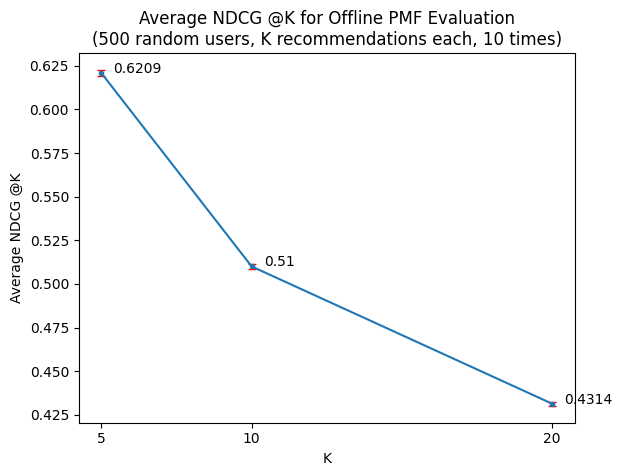

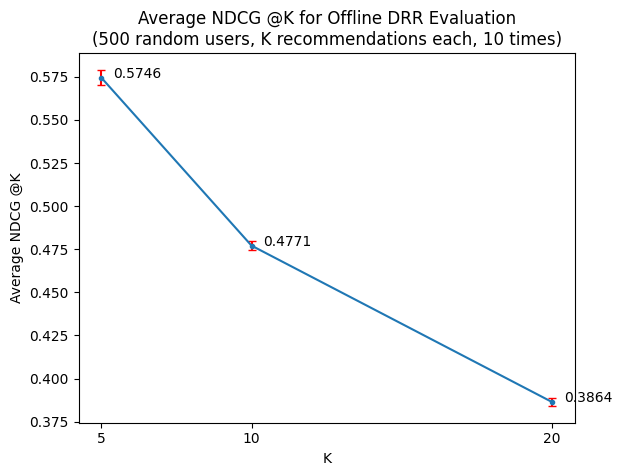

In [ ]:
# Evaluation @K Graphing

def createEvalPlot(title, ylabel, xlabel, filename, x, y, e, e_x_off, e_y_off):
  plt.figure()
  plt.errorbar(x, y, yerr=e, fmt='.-', ecolor="red", capsize=3)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xticks(x)
  for i, j in zip(x, y):
      plt.annotate(str(round(j, 4)), xy=(i+e_x_off, j+e_y_off))
  plt.savefig(filename)

# Combine data
pmf_offline_eval_data = [pmf_fives, pmf_tens, pmf_twenties]
offline_eval_data = [drr_fives, drr_tens, drr_twenties]
# online_eval_data = [online_fives, online_tens, online_twenties]

# Calculate means and stds for graphing
pmf_offline_means, pmf_offline_stds = [], []
offline_means, offline_stds = [], []
# online_means, online_stds = [], []
for d in pmf_offline_eval_data:
    pmf_offline_means.append(np.mean(d))
    pmf_offline_stds.append(np.std(d))

for d in offline_eval_data:
    offline_means.append(np.mean(d))
    offline_stds.append(np.std(d))

# for d in online_eval_data:
#     online_means.append(np.mean(d))
#     online_stds.append(np.std(d))

print(pmf_offline_means)
print(pmf_offline_stds)
print(offline_means)
print(offline_stds)
# print(online_means)
# print(online_stds)


# Create and save eval plots
createEvalPlot("Average NDCG @K for Offline PMF Evaluation\n(500 random users, K recommendations each, 20 times)",
                "Average NDCG @K",
                "K",
                output_path + "pmf_offline_eval.png",
                T_ndcgs,
                pmf_offline_means,
                pmf_offline_stds,
                0.4,
                0)

createEvalPlot("Average NDCG @K for Offline DRR Evaluation\n(500 random users, K recommendations each, 20 times)",
                "Average NDCG @K",
                "K",
                output_path + "offline_eval.png",
                T_ndcgs,
                offline_means,
                offline_stds,
                0.4,
                0)

# createEvalPlot(
#     "Average Reward @K for Online DRR Evaluation\n(10,000 recommendations at each K, 20 times)",
#     "Average Reward @K",
#     "K",
#     output_path + "online_eval.png",
#     Ts,
#     online_means,
#     online_stds,
#     0.3,
#     -0.004)